In [17]:
# Source: https://github.com/bnsreenu/python_for_microscopists/blob/master/263_Object%20localization%20in%20images%E2%80%8B_using_GAP_layer/263_Object%20localization%20in%20images%E2%80%8B_using_GAP_layer.py
import numpy as np
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2     
from google.colab.patches import cv2_imshow
from keras.models import Model   
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input, decode_predictions
from PIL import Image

In [18]:
input_size = 527 # efficientB6
input_dim = (528,528) # efficientB6
# input_size = 224 # vgg19, resnet, efficientB0
# input_dim = (224,224) # vgg19, resnet, efficientB0
#input_size = 296 # InceptionV3
#input_dim = (299,299) # InceptionV3
#feats = 512 # vgg19
#feats = 1280 # efficientB0
feats = 2304 # efficientB6
#feats = 2048 # resnet, InceptionV3

#Import the resnet50 model
#model = ResNet50(weights='imagenet')
#model = VGG19(weights='imagenet')
#model = InceptionV3(weights='imagenet')
model = EfficientNetB6(weights='imagenet')
print(model.summary()) #Notice the Global Average Pooling layer at the last but onemodel = VGG19(weights='imagenet')


Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 528, 528, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 528, 528, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 528, 528, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                     

In [19]:
# Get weights for the prediction layer (last layer)
# We should see 2048 weights for each of the 1000 classes (2048,1000)
last_layer_weights = model.layers[-1].get_weights()[0]  #Predictions layer

resnet_layer = -3
vgg19_layer = -6
inception_layer = -3
efficientB0_layer = -4
efficientB6_layer = -4

#Output both predictions (last layer) and conv5_block3_add (just before final activation layer)
transfer_model = Model(inputs=model.input, outputs=(model.layers[efficientB6_layer].output, model.layers[-1].output)) 

In [20]:
def get_heatmap(input_img):
    img_tensor = np.expand_dims(input_img, axis=0)
    preprocessed_img = preprocess_input(img_tensor)
    
    #Get the predictions and the output of last conv. layer. 
    last_conv_output, pred_vec = transfer_model.predict(preprocessed_img)
    print('last_conv_output',last_conv_output.shape)
    #Last conv. output for the image
    last_conv_output = np.squeeze(last_conv_output) # usually 7x7xfeats
    #Prediction for the image
    pred = np.argmax(pred_vec)
    
    decode_predictions(pred_vec, top=1)
    
    # spline interpolation to resize each filtered image to size of original image 
    h = int(input_img.shape[0]/last_conv_output.shape[0])
    w = int(input_img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1) # dim: imput_size x imput_size x feats
    print('upsampled_last_conv_output',upsampled_last_conv_output.shape)

    #Get the weights from the last layer for the prediction class
    last_layer_weights_for_pred = last_layer_weights[:, pred] # dim: (2048,) 
    print('last_layer_weights_for_pred',last_layer_weights_for_pred.shape)
    
    #To generate the final heat map. 
    #Reshape the upsampled last conv. output to n x filters and multiply (dot product) 
    # with the last layer weigths for the prediction. 
    # Reshape back to the image size for easy overlay onto the original image. 
    heat_map = np.dot(upsampled_last_conv_output.reshape((input_size*input_size, feats)), 
                  last_layer_weights_for_pred).reshape(input_size,input_size)
    return heat_map

In [21]:
fname = '2022-04-19 15-46-15.mp4'

sample = cv2.VideoCapture(fname)

In [22]:
def play_video_format(video_data):
    # Read until video is completed
    i = 0
    while (video_data.isOpened()):
        # Capture frame-by-frame
        ret, frame = video_data.read()
        if ret == True:
          i += 1
          if i < 125:
            continue
          img = Image.fromarray(frame, 'RGB')
          img = img.resize(input_dim)
          img = np.array(img)
          cv2_imshow(img)

          # Display the resulting frame
          heat_map = get_heatmap(img)
          fig, ax = plt.subplots()
          ax.imshow(img)
          ax.imshow(heat_map, cmap='jet', alpha=0.5)
          plt.show()
          break

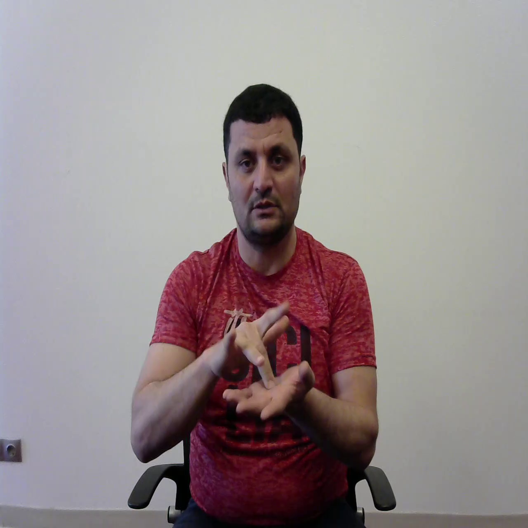

last_conv_output (1, 17, 17, 2304)
upsampled_last_conv_output (527, 527, 2304)
last_layer_weights_for_pred (2304,)


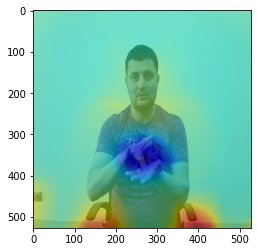

In [23]:
play_video_format(sample)